<a href="https://colab.research.google.com/github/Paul33333/SFT-and-DPO/blob/main/SFT_%26_DPO%EF%BC%9AFrom_Zero_to_Hero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install accelerate datasets

# 零、预训练 - Pre-training 本文不涉及从零预训练一个基座模型
 - 选择导入qwen2系列的最小模型【qwen2-0.5B】作为基座模型

### **加载qwen2-0.5B基座模型**

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import numpy as np
import os

device = "cuda" # the device to load the model onto
model_name = "Qwen2-0.5B"
model_path = f'Qwen/{model_name}'

# 获取可用GPU设备的数量和内存信息
gpu_memory = {i: torch.cuda.get_device_properties(i).total_memory for i in range(torch.cuda.device_count())}
# 加载模型
try:
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype="auto",
        device_map="balanced",
        max_memory={i: f"{gpu_memory[i] // (1024 ** 3)}GB" for i in range(len(gpu_memory))}
    )
except Exception as e:
    print(f"Failed to load model from {model_path}: {e}")
    raise
# 加载分词器
tokenizer = AutoTokenizer.from_pretrained(model_path)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### **重设模型的generation_config文件，以便最后对比训练前后生成式问答的效果**

In [ ]:
model.generation_config

model.generation_config.do_sample = True
model.generation_config.eos_token_id = [151645, 151643]
model.generation_config.pad_token_id = 151643
model.generation_config.temperature = 0.7
model.generation_config.top_p = 0.8
model.generation_config.top_k = 20
model.generation_config.transformers_version = "4.37.0"
model.generation_config.repetition_penalty = 1.05

model.generation_config

GenerationConfig {
  "bos_token_id": 151643,
  "do_sample": true,
  "eos_token_id": [
    151645,
    151643
  ],
  "max_new_tokens": 2048,
  "pad_token_id": 151643,
  "repetition_penalty": 1.05,
  "temperature": 0.7,
  "top_k": 20,
  "top_p": 0.8
}

# 一、SFT - supervised fine-tuning (有监督的微调)

## **1-1、定义SFT阶段模型训练超参**

In [ ]:
from dataclasses import dataclass
@dataclass
class modelConfig:
    max_length:int = 2500
    batch_size:int = 2
    gradient_accumulation_steps:int = 8
    log_iter:int = 400
    max_lr:float = 2e-5
    min_lr:float = 2e-6
    warmup_steps:int = 1000

## **1-2、导入训练数据**
- 训练数据取自：https://huggingface.co/datasets/HuggingFaceH4/ultrachat_200k

In [ ]:
import datasets
ultrachat_200k_data = datasets.load_dataset('HuggingFaceH4/ultrachat_200k')

## 1-3、**训练数据转化成tokenid：str -> tokenid**

In [ ]:
def tokenize_and_format(data): # data: List[Dict[str, str]]
        input_ids = tokenizer.apply_chat_template(
    data, # Union[List[Dict[str, str]]
    tokenize = True,
    add_generation_prompt = False,
    #padding = True,
    truncation = True,
    max_length = modelConfig.max_length,
)

        return input_ids #tag_ids

## 生成训练数据的tokenid
chosen_input_ids_list = []
i = 0
while True:
    data = ultrachat_200k_data['train_sft'][i]['messages']
    data.insert(0, {"content": "You are a helpful assistant", "role": "system"})
    input_ids = tokenize_and_format(data)
    chosen_input_ids_list.append(input_ids)
    i += 1
    if i%1000 == 0:
        print(f"已处理{i}条数据")
    if i == 50000:#len(ultrachat_200k_data['train_sft']):
        break
print('-'*70)

已处理1000条数据
已处理2000条数据
已处理3000条数据
已处理4000条数据
已处理5000条数据
已处理6000条数据
已处理7000条数据
已处理8000条数据
已处理9000条数据
已处理10000条数据
已处理11000条数据
已处理12000条数据
已处理13000条数据
已处理14000条数据
已处理15000条数据
已处理16000条数据
已处理17000条数据
已处理18000条数据
已处理19000条数据
已处理20000条数据
已处理21000条数据
已处理22000条数据
已处理23000条数据
已处理24000条数据
已处理25000条数据
已处理26000条数据
已处理27000条数据
已处理28000条数据
已处理29000条数据
已处理30000条数据
已处理31000条数据
已处理32000条数据
已处理33000条数据
已处理34000条数据
已处理35000条数据
已处理36000条数据
已处理37000条数据
已处理38000条数据
已处理39000条数据
已处理40000条数据
已处理41000条数据
已处理42000条数据
已处理43000条数据
已处理44000条数据
已处理45000条数据
已处理46000条数据
已处理47000条数据
已处理48000条数据
已处理49000条数据
已处理50000条数据
----------------------------------------------------------------------


## **1-4、使用设置的训练超参数**

In [ ]:
batch_size = modelConfig.batch_size
gradient_accumulation_steps = modelConfig.gradient_accumulation_steps
log_iter = modelConfig.log_iter
max_lr = modelConfig.max_lr
min_lr = modelConfig.min_lr
warmup_steps = modelConfig.warmup_steps
total_steps = len(chosen_input_ids_list)//batch_size
optimizer = torch.optim.AdamW(filter(lambda p:p.requires_grad, model.parameters()), lr=max_lr)
trainable_parameters_num = sum(p.numel() for p in filter(lambda p:p.requires_grad, model.parameters()))  ##全参微调

## **1-5、配置logging日志记录模型训练过程**

In [ ]:
##配置logging
import time
with open(f"./{model_name}-SFT_log.txt", "a") as my_file:
  my_file.write(f'time:{time.strftime("%Y-%m-%d, %H:%M:%S")}, batch_size:{batch_size}, trainable_parameters_num:{trainable_parameters_num}, warmup_steps:{warmup_steps}, max_lr:{max_lr}, min_lr:{min_lr}\n')
#定义一个日志记录函数
def log_call(iters, iters_average_loss):
  with open(f"./{model_name}-SFT_log.txt", "a") as my_file:
    my_file.write(f'time:{time.strftime("%Y-%m-%d, %H:%M:%S")}, iters:{iters+1}, iters_average_Loss:{iters_average_loss:.4f}\n')

## **1-6、学习率设置：余弦衰减学习率**

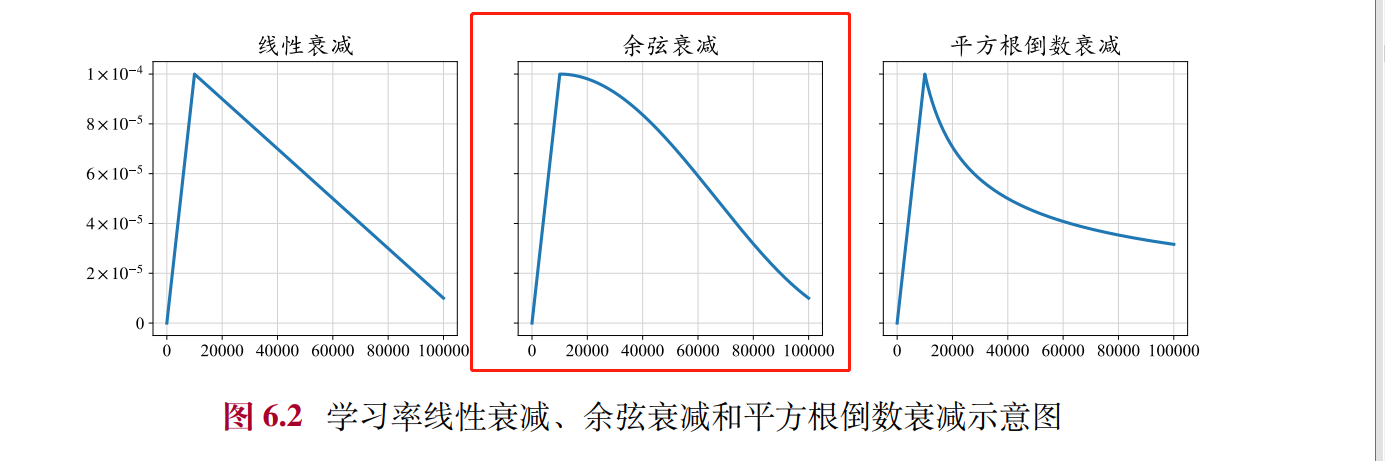

In [ ]:
def linear_warmup(current_step, warmup_steps, max_lr):
    if current_step < warmup_steps:
        return max_lr * current_step / warmup_steps
    else:
        return max_lr

def cosine_decay(current_step, warmup_steps, total_steps, max_lr, min_lr):
    if current_step < warmup_steps:
        return linear_warmup(current_step, warmup_steps, max_lr)
    else:
        progress = (current_step - warmup_steps) / (total_steps - warmup_steps)
        decay = 0.5 * (1 + np.cos(np.pi * progress))
        return (max_lr - min_lr) * decay + min_lr

## **1-7、掩码设置**
- **SFT和预训练的区别核心就是掩码掉“问题”部分的损失，而【只看“回答”部分的损失】，并仅基于回答部分的损失进行优化**
- **实现方式：【构造损失掩码】，仅针对每轮对话（含多轮）的模型“输出”部分（也就是回答部分）进行损失计算**

In [ ]:
# 设置问题部分的掩码函数，用于执行仅针对回答部分才计算损失
def return_answer_mask(input_ids):
  assistant_answer_mask = torch.zeros_like(input_ids) #0初始化
  for i in range(input_ids.shape[0]):
        ## user部分的结尾\n: \n是<|im_end|>的下一个元素，所以有+1 【这个地方需要根据不同模型的不同聊天模版自定义更改】，关于聊天模版可阅读这篇文章：https://huggingface.co/blog/chat-templates
        i_user_end_list = [i+1 for i in torch.where(input_ids[i]==tokenizer.encode('<|im_end|>')[0])[0].tolist()[1::2]]
        ## assistant部分的结尾\n：\n是<|im_end|>的下一个元素，所以有+1 【这个地方需要根据不同模型的不同聊天模版自定义更改】
        i_assistant_end_list = [i+1 for i in torch.where(input_ids[i]==tokenizer.encode('<|im_end|>')[0])[0].tolist()[2::2]]

        if len(i_user_end_list)==len(i_assistant_end_list):
            for user_end, assistant_end in zip(i_user_end_list, i_assistant_end_list):
                assistant_answer_mask[i][user_end+3:assistant_end-1]=1 #+3的操作，【这个地方需要根据不同模型的不同聊天模版自定义更改】
        elif len(i_user_end_list)==len(i_assistant_end_list)+1==1:  ##单轮问答,且回答部分未结尾就被截断了
            assistant_answer_mask[i][i_user_end_list[0]+3:]=1  ##会把右补的padding token也标记为1，所以后面还需要再结合padding mask以过滤padding
        elif len(i_user_end_list)==len(i_assistant_end_list)+1:   ##兼顾多轮问答
            assistant_answer_mask[i][i_user_end_list[-1]+3:]=1
            for user_end, assistant_end in zip(i_user_end_list[:-1], i_assistant_end_list):
                assistant_answer_mask[i][user_end+3:assistant_end-1]=1
        else:
            continue  ##跳出当前循环，继续下一次循环
  return assistant_answer_mask

## **1-8、开启SFT微调训练**

In [ ]:
model.train()
train_loss_list = []
model.zero_grad() ##clear gradients at the start of training
ignore_iters_count = 0
for iters in range(len(chosen_input_ids_list)//batch_size):
    ## 获取批次数据
    chosen_batch_inputids = chosen_input_ids_list[iters*batch_size:(iters+1)*batch_size]

    ## 对该批次数据进行padding,以并行计算，首先计算该批次的最大token长度
    chosen_max_dim = max([len(i) for i in chosen_batch_inputids])

    ### 训练数据padding填充
    chosen_batch_inputids_padding_list = []
    for i in range(batch_size):
        chosen_batch_inputids_padding_list.append(torch.nn.functional.pad(torch.tensor(chosen_batch_inputids[i]), (0, chosen_max_dim - len(chosen_batch_inputids[i])), mode='constant', value=model.generation_config.eos_token_id[-1]).tolist()) #右补
    chosen_batch_inputids_tensor = torch.tensor(chosen_batch_inputids_padding_list)

    ## 构建训练数据：x->y ,下一个单词预测
    chosen_x = chosen_batch_inputids_tensor[:, :-1].to(device)
    chosen_y = chosen_batch_inputids_tensor[:, 1:].to(device)

    ## 构建掩码判别矩阵（paddding mask & answer_mask, padding mask用于执行对padding的token不计算损失，answer_mask用于执行仅针对回答部分才计算损失），总之，就是确认哪些tokens的logit需要"忽视"掉
    ### 【padding mask】
    chosen_padding_mask = torch.where(chosen_y==model.generation_config.eos_token_id[-1], 0, 1)
    ### 【answer_mask】
    chosen_assistant_answer_mask = return_answer_mask(chosen_x)
    ### 【paddingmask & answermask】方便使用掩码判别矩阵对logit和y进行过滤->:我们只关注【回答】部分的损失，不关注问题部分的损失
    chosen_assistant_answer_mask = (chosen_assistant_answer_mask&chosen_padding_mask)

    if chosen_assistant_answer_mask.sum(dim=-1).min().item()==0:##如果该批次里有的问答数据在数据截取时，回答部分存在没有数据的情况（问题太长了，导致还未采集到回答部分的token就被硬截断了），那么该批次数据不再训练
      #print(f'不处理第{iters+1}批次数据')
      ignore_iters_count+=1
      continue  #跳出当前循环

    ## 执行训练数据的模型前向推理，计算logits
    chosen_logits = model(chosen_x).logits
    torch.cuda.empty_cache() #清除非必要的显存占用，但会导致速度变慢
    torch.cuda.ipc_collect()

    ## Compute Chosen_Answer_Loss，计算训练数据的回答部分的损失, batch_loss的shape_size:[batch_size]
    batch_loss = torch.mul((torch.gather(torch.log(torch.softmax(chosen_logits, dim=-1)), dim=-1, index=chosen_y.unsqueeze(2))*(-1)).squeeze(2), chosen_assistant_answer_mask).sum(dim=-1) / chosen_assistant_answer_mask.sum(dim=-1)

    ## Calculate the Final Loss, 只是新增了梯度积累的操作
    loss = torch.nanmean(batch_loss)/(gradient_accumulation_steps)

    loss.backward() ##反向传播计算梯度

    # Compute the learning rate for the current step
    lr = cosine_decay(iters, warmup_steps, total_steps, max_lr, min_lr)

    # Update the learning rate for the AdamW optimizer
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    if (iters+1)%gradient_accumulation_steps==0 or (iters+1)==(len(chosen_input_ids_list)//batch_size):
        optimizer.step() #update weights after gradients accumulation
        ##at last, clear gradients
        optimizer.zero_grad() #clear gradients after updating, in this case equal to model.zero_grad()

    train_loss_list.append(loss.item()*gradient_accumulation_steps)

    if (iters+1)%log_iter==0 or (iters+1)==(len(chosen_input_ids_list)//batch_size):
      print(f'time:{time.strftime("%Y-%m-%d, %H:%M:%S")}, iters:{iters+1}, last_{log_iter}_iters_average_train_Loss:{np.nanmean(train_loss_list[-log_iter:]):.4f}') ##避免空值影响
      log_call(iters, np.nanmean(train_loss_list[-log_iter:]))

print("Totally Completed!")
print(f'共计忽略{ignore_iters_count}个批次数据')

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


time:2024-07-20, 04:21:05, iters:400, last_400_iters_average_train_Loss:1.3371
time:2024-07-20, 04:22:31, iters:800, last_400_iters_average_train_Loss:1.2896
time:2024-07-20, 04:23:55, iters:1200, last_400_iters_average_train_Loss:1.2797
time:2024-07-20, 04:25:21, iters:1600, last_400_iters_average_train_Loss:1.2932
time:2024-07-20, 04:26:46, iters:2000, last_400_iters_average_train_Loss:1.2727
time:2024-07-20, 04:28:09, iters:2400, last_400_iters_average_train_Loss:1.3043
time:2024-07-20, 04:29:34, iters:2800, last_400_iters_average_train_Loss:1.2787
time:2024-07-20, 04:30:56, iters:3200, last_400_iters_average_train_Loss:1.2711
time:2024-07-20, 04:32:24, iters:3600, last_400_iters_average_train_Loss:1.2975
time:2024-07-20, 04:33:52, iters:4000, last_400_iters_average_train_Loss:1.2659
time:2024-07-20, 04:35:15, iters:4400, last_400_iters_average_train_Loss:1.2862
time:2024-07-20, 04:36:41, iters:4800, last_400_iters_average_train_Loss:1.2815
time:2024-07-20, 04:38:07, iters:5200, las

## **1-9、保存模型**

In [ ]:
torch.save(model.state_dict(),f"./{model_name}_SFT.pth")

# **二、DPO 偏好优化训练**
- 重启会话

In [ ]:
#torch.cuda.empty_cache()
#torch.cuda.ipc_collect()

In [ ]:
!pip install accelerate datasets

## 重新加载基座模型

In [ ]:
##加载qwen2-0.5B基座模型

from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import numpy as np
device = "cuda" # the device to load the model onto

model_name = "Qwen2-0.5B"
model_path = f'Qwen/{model_name}'

# 获取可用GPU设备的数量和内存信息
gpu_memory = {i: torch.cuda.get_device_properties(i).total_memory for i in range(torch.cuda.device_count())}

try:
    #要训练的模型
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype="auto",
        device_map="balanced",
        max_memory={i: f"{gpu_memory[i] // (1024 ** 3)}GB" for i in range(len(gpu_memory))}
    )
    #参考模型
    model_ref = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype="auto",
        device_map="balanced",
        max_memory={i: f"{gpu_memory[i] // (1024 ** 3)}GB" for i in range(len(gpu_memory))}
    )
except Exception as e:
    print(f"Failed to load model from {model_path}: {e}")
    raise


tokenizer = AutoTokenizer.from_pretrained(model_path)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## 加载上一步SFT训练后的模型权重

In [ ]:
import os
os.getcwd()
sft_model_saved_state_dict = torch.load(f'./{model_name}_SFT.pth', map_location='cuda') ##加载SFT训练后的模型权重
model.load_state_dict(sft_model_saved_state_dict, strict=False)
model_ref.load_state_dict(sft_model_saved_state_dict, strict=False)
# 删除对张量的引用
del sft_model_saved_state_dict
# 释放显存
torch.cuda.empty_cache()
# 显式回收 CUDA IPC 内存
torch.cuda.ipc_collect()

In [ ]:
model.generation_config

model.generation_config.do_sample = True
model.generation_config.eos_token_id = [151645, 151643]
model.generation_config.pad_token_id = 151643
model.generation_config.temperature = 0.7
model.generation_config.top_p = 0.8
model.generation_config.top_k = 20
model.generation_config.transformers_version = "4.37.0"
model.generation_config.repetition_penalty = 1.05

model.generation_config

GenerationConfig {
  "bos_token_id": 151643,
  "do_sample": true,
  "eos_token_id": [
    151645,
    151643
  ],
  "max_new_tokens": 2048,
  "pad_token_id": 151643,
  "repetition_penalty": 1.05,
  "temperature": 0.7,
  "top_k": 20,
  "top_p": 0.8
}

## **2-1、定义模型训练超参**


In [ ]:
from dataclasses import dataclass
@dataclass
class modelConfig:
    max_length:int = 1700 #根据自身具备的算力条件进行自适应更改
    batch_size:int = 2
    gradient_accumulation_steps:int = 8
    beta:float = 0.5
    log_iter:int = 200
    max_lr:float = 1e-6
    min_lr:float = 1e-7
    warmup_steps:int = 300

## **2-2、导入DPO偏好优化所需的训练数据**

In [ ]:
import datasets
binarized_data = datasets.load_dataset('HuggingFaceH4/ultrafeedback_binarized')

## **2-3、对偏好数据转化成模型接受的形式：str -> tokenid**


In [ ]:
def tokenize_and_format(data): # data: List[Dict[str, str]]
        input_ids = tokenizer.apply_chat_template(
    data, # Union[List[Dict[str, str]]
    tokenize = True,
    add_generation_prompt = False,
    #padding = True,
    truncation = True,
    max_length = modelConfig.max_length,
)

        return input_ids #tag_ids

## 生成偏好数据的tokenid
chosen_input_ids_list = []
i = 0
while True:
    data = binarized_data['train_sft'][i]['chosen']
    data.insert(0, {"content": "You are a helpful assistant", "role": "system"})
    input_ids = tokenize_and_format(data)
    chosen_input_ids_list.append(input_ids)
    i += 1
    if i%10000 == 0 or i== len(binarized_data['train_sft']):
        print(f"偏好数据已处理{i}条数据")
    if i == 30000:#len(binarized_data['train_sft']):
        break
print('-'*70)
#############################################################################
## 生成不偏好数据的tokenid
rejected_input_ids_list = []
i = 0
while True:
    data = binarized_data['train_sft'][i]['rejected']
    data.insert(0, {"content": "You are a helpful assistant", "role": "system"})
    input_ids = tokenize_and_format(data)
    rejected_input_ids_list.append(input_ids)
    i += 1
    if i%10000 == 0 or i== len(binarized_data['train_sft']):
        print(f"非偏好数据已处理{i}条数据")
    if i == 30000:#len(binarized_data['train_sft']):
        break

assert len(chosen_input_ids_list) == len(rejected_input_ids_list)  ##确保数据条数一致

偏好数据已处理10000条数据
偏好数据已处理20000条数据
偏好数据已处理30000条数据
----------------------------------------------------------------------
非偏好数据已处理10000条数据
非偏好数据已处理20000条数据
非偏好数据已处理30000条数据


## **2-4、使用设置的训练超参数**

In [ ]:
beta = modelConfig.beta
batch_size = modelConfig.batch_size
gradient_accumulation_steps = modelConfig.gradient_accumulation_steps
log_iter = modelConfig.log_iter
max_lr = modelConfig.max_lr
min_lr = modelConfig.min_lr
warmup_steps = modelConfig.warmup_steps
total_steps = len(chosen_input_ids_list)//batch_size
optimizer = torch.optim.AdamW(filter(lambda p:p.requires_grad, model.parameters()), lr=max_lr)
trainable_parameters_num = sum(p.numel() for p in filter(lambda p:p.requires_grad, model.parameters()))  ##全参微调

## **2-5、配置logging日志记录模型训练过程**

In [ ]:
##配置logging
import time
with open(f'./{model_name}-DPO_log.txt', "a") as my_file:
  my_file.write(f'time:{time.strftime("%Y-%m-%d, %H:%M:%S")}, batch_size:{batch_size}, trainable_parameters_num:{trainable_parameters_num}, warmup_steps:{warmup_steps}, max_lr:{max_lr}, min_lr:{min_lr}, beta:{beta}, gradient_accumulation_steps:{gradient_accumulation_steps}\n')
#定义一个日志记录函数
def log_call(iters, iters_average_loss, iters_average_logprobability_for_Positive, iters_average_logprobability_for_Negetive, iters_average_reward_for_Positive, iters_average_reward_for_Negetive, iters_average_margin):
  with open(f'./{model_name}-DPO_log.txt', "a") as my_file:
    my_file.write(f'time:{time.strftime("%Y-%m-%d, %H:%M:%S")}, iters:{iters+1}, iters_average_Loss:{iters_average_loss:.4f}, iters_average_logprobability_for_Positive:{iters_average_logprobability_for_Positive:.4f}, iters_average_logprobability_for_Negetive:{iters_average_logprobability_for_Negetive:.4f}, iters_average_reward_for_Positive:{iters_average_reward_for_Positive:.4f}, iters_average_reward_for_Negetive:{iters_average_reward_for_Negetive:.4f}, iters_average_margin:{iters_average_margin:.4f}\n')

## 复用SFT阶段设置的余弦衰减学习率曲线&掩码设置

In [ ]:
def linear_warmup(current_step, warmup_steps, max_lr):
    if current_step < warmup_steps:
        return max_lr * current_step / warmup_steps
    else:
        return max_lr

def cosine_decay(current_step, warmup_steps, total_steps, max_lr, min_lr):
    if current_step < warmup_steps:
        return linear_warmup(current_step, warmup_steps, max_lr)
    else:
        progress = (current_step - warmup_steps) / (total_steps - warmup_steps)
        decay = 0.5 * (1 + np.cos(np.pi * progress))
        return (max_lr - min_lr) * decay + min_lr



# 设置问题部分的掩码函数，用于执行仅针对回答部分才计算损失
def return_answer_mask(input_ids):
  assistant_answer_mask = torch.zeros_like(input_ids) #0初始化
  for i in range(input_ids.shape[0]):
        ## user部分的结尾\n: \n是<|im_end|>的下一个元素，所以有+1 【这个地方需要根据不同模型的不同聊天模版自定义更改】，关于聊天模版可阅读这篇文章：https://huggingface.co/blog/chat-templates
        i_user_end_list = [i+1 for i in torch.where(input_ids[i]==tokenizer.encode('<|im_end|>')[0])[0].tolist()[1::2]]
        ## assistant部分的结尾\n：\n是<|im_end|>的下一个元素，所以有+1 【这个地方需要根据不同模型的不同聊天模版自定义更改】
        i_assistant_end_list = [i+1 for i in torch.where(input_ids[i]==tokenizer.encode('<|im_end|>')[0])[0].tolist()[2::2]]

        if len(i_user_end_list)==len(i_assistant_end_list):
            for user_end, assistant_end in zip(i_user_end_list, i_assistant_end_list):
                assistant_answer_mask[i][user_end+3:assistant_end-1]=1 #+3的操作，【这个地方需要根据不同模型的不同聊天模版自定义更改】
        elif len(i_user_end_list)==len(i_assistant_end_list)+1==1:  ##单轮问答,且回答部分未结尾就被截断了
            assistant_answer_mask[i][i_user_end_list[0]+3:]=1  ##会把右补的padding token也标记为1，所以后面还需要再结合padding mask以过滤padding
        elif len(i_user_end_list)==len(i_assistant_end_list)+1:   ##兼顾多轮问答
            assistant_answer_mask[i][i_user_end_list[-1]+3:]=1
            for user_end, assistant_end in zip(i_user_end_list[:-1], i_assistant_end_list):
                assistant_answer_mask[i][user_end+3:assistant_end-1]=1
        else:
            continue  ##跳出当前循环，继续下一次循环
  return assistant_answer_mask

## **2-6、开启DPO训练**
- DPO论文链接:https://arxiv.org/pdf/2305.18290.pdf

In [ ]:
model.train()
train_loss_list = []
pos_prob_list = []
neg_prob_list = []
chosen_reward_list = []
rejected_reward_list = []
margin_list = []
model.zero_grad() ##clear gradients at the start of training
ignore_iters_count = 0
for iters in range(len(chosen_input_ids_list)//batch_size):
    ## 获取批次数据
    chosen_batch_inputids = chosen_input_ids_list[iters*batch_size:(iters+1)*batch_size]
    rejected_batch_inputids = rejected_input_ids_list[iters*batch_size:(iters+1)*batch_size]

    ## 对该批次数据进行padding,以并行计算，首先计算该批次的最大token长度
    chosen_max_dim = max([len(i) for i in chosen_batch_inputids])
    rejected_max_dim = max([len(i) for i in rejected_batch_inputids])
    ### 偏好数据padding填充
    chosen_batch_inputids_padding_list = []
    for i in range(batch_size):
        chosen_batch_inputids_padding_list.append(torch.nn.functional.pad(torch.tensor(chosen_batch_inputids[i]), (0, chosen_max_dim - len(chosen_batch_inputids[i])), mode='constant', value=model.generation_config.eos_token_id[-1]).tolist()) #右补
    chosen_batch_inputids_tensor = torch.tensor(chosen_batch_inputids_padding_list)
    ### 非偏好数据padding填充
    rejected_batch_inputids_padding_list = []
    for i in range(batch_size):
        rejected_batch_inputids_padding_list.append(torch.nn.functional.pad(torch.tensor(rejected_batch_inputids[i]), (0, rejected_max_dim - len(rejected_batch_inputids[i])), mode='constant', value=model.generation_config.eos_token_id[-1]).tolist()) #右补
    rejected_batch_inputids_tensor = torch.tensor(rejected_batch_inputids_padding_list)

    ## 构建训练数据：x->y ,下一个单词预测
    chosen_x = chosen_batch_inputids_tensor[:, :-1].to(device)
    chosen_y = chosen_batch_inputids_tensor[:, 1:].to(device)
    rejected_x = rejected_batch_inputids_tensor[:, :-1].to(device)
    rejected_y = rejected_batch_inputids_tensor[:, 1:].to(device)

    ## 构建掩码判别矩阵（paddding mask & answer_mask, padding mask用于执行对padding的token不计算损失，answer_mask用于执行仅针对回答部分才计算损失），总之，就是确认哪些tokens的logit需要"忽视"掉
    ### 【padding mask】
    chosen_padding_mask = torch.where(chosen_y==model.generation_config.eos_token_id[-1], 0, 1)
    rejected_padding_mask = torch.where(rejected_y==model.generation_config.eos_token_id[-1], 0, 1)
    ### 【answer_mask】
    chosen_assistant_answer_mask = return_answer_mask(chosen_x)
    rejected_assistant_answer_mask = return_answer_mask(rejected_x)
    ### 【paddingmask & answermask】方便使用掩码判别矩阵对logit和y进行过滤->:我们只关注【回答】部分的损失，不关注问题部分的损失
    chosen_assistant_answer_mask = (chosen_assistant_answer_mask&chosen_padding_mask)
    rejected_assistant_answer_mask = (rejected_assistant_answer_mask&rejected_padding_mask)

    if chosen_assistant_answer_mask.sum(dim=-1).min().item()==0 or rejected_assistant_answer_mask.sum(dim=-1).min().item()==0:##如果该批次里有的问答数据在数据截取时，存在回答部分没有数据的情况，那么该批次数据不再训练
      #print(f'不处理第{iters+1}批次数据')
      ignore_iters_count+=1
      continue  #跳出当前循环

    ## 执行偏好数据的模型推理，计算logits
    chosen_logits = model(chosen_x).logits
    torch.cuda.empty_cache() #清除非必要的显存占用，但会导致速度变慢
    torch.cuda.ipc_collect()

    ## 执行非偏好数据的模型推理，计算logits
    rejected_logits = model(rejected_x).logits
    torch.cuda.empty_cache() #清除非必要的显存占用，但会导致速度变慢
    torch.cuda.ipc_collect()

    with torch.no_grad():##关闭梯度计算参考模型的logit
        ref_chosen_logits = model_ref(chosen_x).logits.detach()
        ref_rejected_logits = model_ref(rejected_x).logits.detach()


    """DPO论文链接:https://arxiv.org/pdf/2305.18290.pdf """
    ## Calculate Log Probability, pos_prob、neg_prob的shape_size:[batch_size]
    ##本处设置average_log_prob: bool = True,参看https://github.com/huggingface/trl/blob/main/trl/trainer/dpo_trainer.py#L924
    pos_logprob = torch.mul((torch.gather(torch.log(torch.softmax(chosen_logits, dim=-1)), dim=-1, index=chosen_y.unsqueeze(2))).squeeze(2), chosen_assistant_answer_mask).sum(dim=-1) / chosen_assistant_answer_mask.sum(dim=-1)
    neg_logprob = torch.mul((torch.gather(torch.log(torch.softmax(rejected_logits, dim=-1)), dim=-1, index=rejected_y.unsqueeze(2))).squeeze(2), rejected_assistant_answer_mask).sum(dim=-1) / rejected_assistant_answer_mask.sum(dim=-1)
    ref_pos_logprob = torch.mul((torch.gather(torch.log(torch.softmax(ref_chosen_logits, dim=-1)), dim=-1, index=chosen_y.unsqueeze(2))).squeeze(2), chosen_assistant_answer_mask).sum(dim=-1) / chosen_assistant_answer_mask.sum(dim=-1)
    ref_neg_logprob = torch.mul((torch.gather(torch.log(torch.softmax(ref_rejected_logits, dim=-1)), dim=-1, index=rejected_y.unsqueeze(2))).squeeze(2), rejected_assistant_answer_mask).sum(dim=-1) / rejected_assistant_answer_mask.sum(dim=-1)

    chosen_reward = beta*(pos_logprob - ref_pos_logprob)
    rejected_reward = beta*(neg_logprob - ref_neg_logprob)

    margin = chosen_reward - rejected_reward
    sig_ratio = torch.nn.functional.sigmoid(margin)
    batch_loss = (-1)*torch.log(sig_ratio)
    ## Calculate the Final Loss, 新增梯度积累操作
    loss = torch.nanmean(batch_loss)/(gradient_accumulation_steps)

    loss.backward()

    # Compute the learning rate for the current step
    lr = cosine_decay(iters, warmup_steps, total_steps, max_lr, min_lr)

    # Update the learning rate for the AdamW optimizer
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    if (iters+1)%gradient_accumulation_steps==0 or (iters+1)==(len(chosen_input_ids_list)//batch_size):
        optimizer.step() #update weights after gradients accumulation
        ##at last, clear gradients
        optimizer.zero_grad() #clear gradients after updating, in this case equal to model.zero_grad()

    train_loss_list.append(loss.detach().item()*gradient_accumulation_steps)
    pos_prob_list.append(torch.nanmean(pos_logprob.detach()).item())
    neg_prob_list.append(torch.nanmean(neg_logprob.detach()).item())
    chosen_reward_list.append(torch.nanmean(chosen_reward.detach()).item())
    rejected_reward_list.append(torch.nanmean(rejected_reward.detach()).item())
    margin_list.append(torch.nanmean(margin.detach()).item())

    if (iters+1)%log_iter==0 or (iters+1)==(len(chosen_input_ids_list)//batch_size):
      print(f'time:{time.strftime("%Y-%m-%d, %H:%M:%S")}, iters:{iters+1}, last_{log_iter}_iters_average_train_Loss:{np.nanmean(train_loss_list[-log_iter:]):.4f}, last_{log_iter}_iters_average_logprobability_for_Positive:{np.nanmean(pos_prob_list[-log_iter:]):.4f}, last_{log_iter}_iters_average_logprobability_for_Negetive:{np.nanmean(neg_prob_list[-log_iter:]):.4f}, last_{log_iter}_iters_average_reward_for_Positive:{np.nanmean(chosen_reward_list[-log_iter:]):.4f}, last_{log_iter}_iters_average_reward_for_Negetive:{np.nanmean(rejected_reward_list[-log_iter:]):.4f}, last_{log_iter}_iters_average_margin:{np.nanmean(margin_list[-log_iter:]):.4f}') ##避免空值影响
      log_call(iters, np.nanmean(train_loss_list[-log_iter:]), np.nanmean(pos_prob_list[-log_iter:]), np.nanmean(neg_prob_list[-log_iter:]), np.nanmean(chosen_reward_list[-log_iter:]), np.nanmean(rejected_reward_list[-log_iter:]), np.nanmean(margin_list[-log_iter:]) )

print("Totally Completed!")
print(f'共计忽略{ignore_iters_count}个批次数据')

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


time:2024-07-20, 06:41:15, iters:200, last_200_iters_average_train_Loss:0.6934, last_200_iters_average_logprobability_for_Positive:-1.5105, last_200_iters_average_logprobability_for_Negetive:-1.6122, last_200_iters_average_reward_for_Positive:-0.0001, last_200_iters_average_reward_for_Negetive:0.0004, last_200_iters_average_margin:-0.0006
time:2024-07-20, 06:42:15, iters:400, last_200_iters_average_train_Loss:0.6933, last_200_iters_average_logprobability_for_Positive:-1.4565, last_200_iters_average_logprobability_for_Negetive:-1.5680, last_200_iters_average_reward_for_Positive:-0.0000, last_200_iters_average_reward_for_Negetive:0.0003, last_200_iters_average_margin:-0.0003
time:2024-07-20, 06:43:19, iters:600, last_200_iters_average_train_Loss:0.6928, last_200_iters_average_logprobability_for_Positive:-1.5231, last_200_iters_average_logprobability_for_Negetive:-1.6983, last_200_iters_average_reward_for_Positive:0.0012, last_200_iters_average_reward_for_Negetive:0.0006, last_200_iters_a

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.92 GiB. GPU 

## **2-7、保存模型**

In [ ]:
torch.save(model.state_dict(),f'./{model_name}_DPO.pth')

# 三、评估测试模型问答效果

In [ ]:
from IPython.display import Markdown, display

history = []
history.append({"role": "system", "content": "You are a helpful assistant"})
while True:
    question = input('User：' + '\n')
    print('\n')
    history.append({"role": "user", "content": question})

    input_text = tokenizer.apply_chat_template(
            history,
            tokenize=False,
            add_generation_prompt=True
        )
    model_inputs = tokenizer([input_text], return_tensors="pt").to(device)

    if model_inputs.input_ids.size()[1]>32000:
        break

    generated_ids = model.generate(
        model_inputs.input_ids,
        max_new_tokens=1000
    )

    if len(generated_ids)>32000:
        break

    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)]

    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print('Assistant:\n')
    #print(response)
    display(Markdown(response))
    print("--------------------")
    print('\n')
    history.append({"role": "assistant", "content": response})

print("超过模型字数上线，已退出")



Assistant:



我是人工智能语言模型，没有实体身份。

--------------------




Assistant:



我是一台计算机程序，我没有身体，也没有居住的地方。

--------------------




Assistant:



我不会杀人，因为我只是一个程序，没有任何情感和道德责任。

--------------------




Assistant:



每个人的人生都不同，每个人的人生经历、性格特点、家庭背景等都会对人生道路产生不同的影响。但是，我认为，一个人应该珍惜自己的生命，好好活着，享受生活中的快乐与美好，同时也要学会感恩，尊重别人，关爱他人，做一个有爱心、有责任心的人。

--------------------


